In [7]:
import numpy as np
import emcee
import zeus
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyu
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import corner
from IPython.display import display, Math
from chainconsumer import ChainConsumer

Text(0, 0.5, 'y')

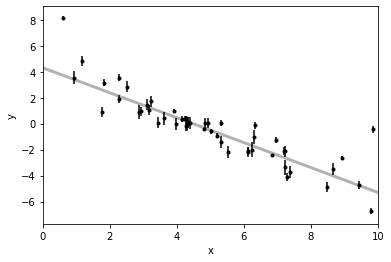

In [8]:
# Setting the problem

np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

# Plot data and true value
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")


In [9]:
# Maximum likelihood

# Gaussian log likelihood

#def log_likelihood(theta, x, y, yerr):
   # m, b, log_f = theta
  #  model = m * x + b
 #   sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
#    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_likelihood(theta):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))


#np.random.seed(42)
#nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
#soln = minimize(nll, initial, args=(x, y, yerr))
#m_ml, b_ml, log_f_ml = soln.x


In [10]:
# Preparation for MCMC

# Log prior: flat on b and log(f), gaussian on m
def log_prior(theta):
    lp = 0.
    m, b, log_f = theta
    
    if -0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        lp = 0.
    else:
        lp = -np.inf
        
    mm = -1.
    msigma = 0.2
    lp -= 0.5*((m - mm)/msigma)**2
    
    return lp

# Log posterior

#def log_probability(theta, x, y, yerr):
 #   lp = log_prior(theta)
  #  if not np.isfinite(lp):
   #     return -np.inf
    #return lp + log_likelihood(theta, x, y, yerr)

def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

# Initial position of mcmc walkers
pos = initial + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

100%|██████████| 5000/5000 [00:11<00:00, 422.95it/s]


Autocorrelation time: [39.07485987 40.30901948 38.91167459]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

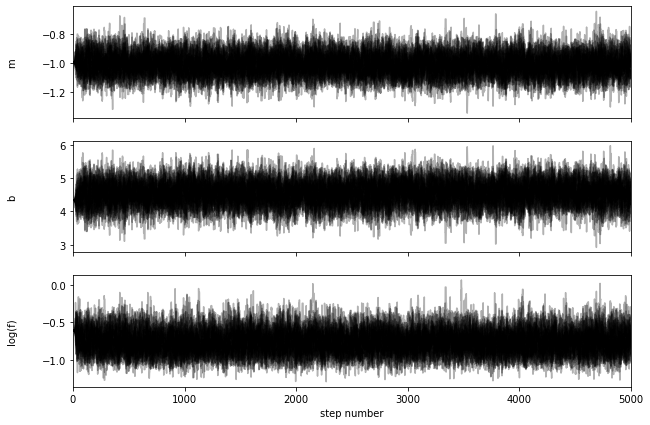

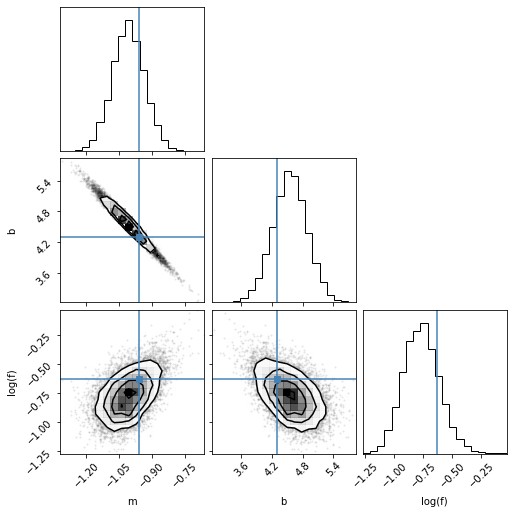

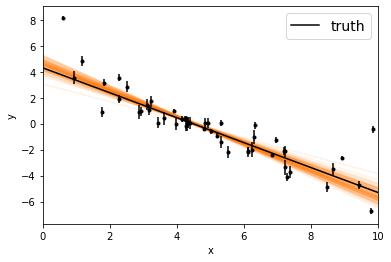

In [11]:
# MCMC with emcee

#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
sampler.run_mcmc(pos, 5000, progress=True)

# Plot of walkers position at each step
fig2, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

# Time of walkers autocorrelation
tau = sampler.get_autocorr_time()
print("Autocorrelation time:", tau)

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

#plotting results
fig3 = corner.corner(flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)])

inds = np.random.randint(len(flat_samples), size=100)
plt.figure(4)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
    
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

# Print parameter estimation with uncertainties based on the 16th, 50th, and 84th percentiles
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

Initialising ensemble of 32 walkers...
Sampling progress : 100%|██████████| 5000/5000 [00:50<00:00, 99.51it/s] 


[5.02282703 5.00396748 5.23829636]
(10464, 3)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

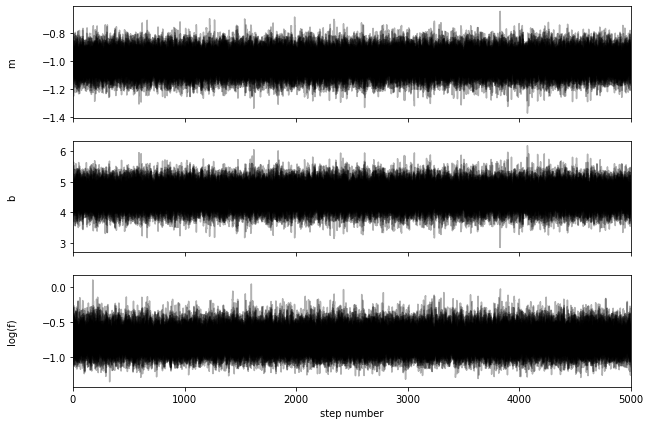

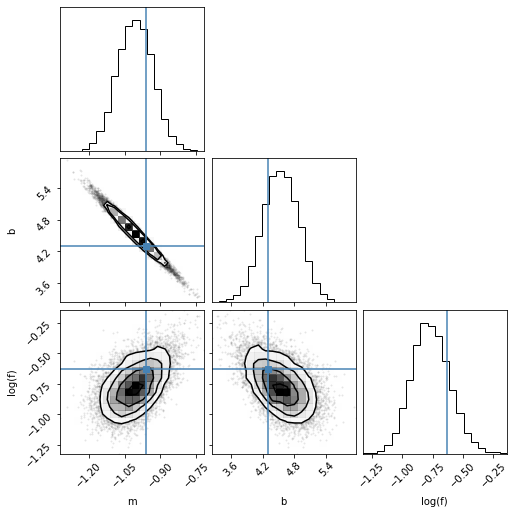

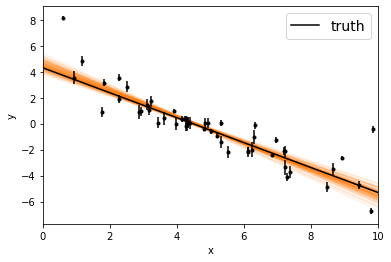

In [12]:
# MCMC with zeus

#zsampler = zeus.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
zsampler = zeus.EnsembleSampler(nwalkers, ndim, log_probability)
zsampler.run_mcmc(pos, 5000, progress=True)

# Plot of walkers position at each step
fig5, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
zsamples = zsampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(zsamples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(zsamples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

# Time of walkers autocorrelation
tau_z = zeus.AutoCorrTime(zsamples)
print(tau_z)

flat_zsamples = zsampler.get_chain(discard=100, thin=15, flat=True)
print(flat_zsamples.shape)

#plotting results
fig6 = corner.corner(flat_zsamples, labels=labels, truths=[m_true, b_true, np.log(f_true)])

inds = np.random.randint(len(flat_samples), size=100)
plt.figure(7)
for ind in inds:
    zsample = flat_zsamples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), zsample[:2]), "C1", alpha=0.1)
    
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

for i in range(ndim):
    mcmc = np.percentile(flat_zsamples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))


In [13]:
# Dynesty nested sampling

rstate= np.random.default_rng(56101)

def log_like(theta):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

# prior transform
def prior_transform(utheta):
    um, ub, ulf = utheta
    m = 5.5 * um - 5.
    b = 10. * ub
    lnf = 11. * ulf - 10.
    
    return m, b, lnf

dsampler = dynesty.DynamicNestedSampler(log_likelihood, prior_transform, ndim=3,
                                        bound='multi', sample='rwalk', rstate=rstate)
dsampler.run_nested()
dres = dsampler.results

16302it [01:11, 227.26it/s, batch: 7 | bound: 27 | nc: 1 | ncall: 329299 | eff(%):  4.790 | loglstar: -17.463 < -12.187 < -12.559 | logz: -23.368 +/-  0.091 | stop:  0.939]            


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The evidence is: 7.053359236991854e-11


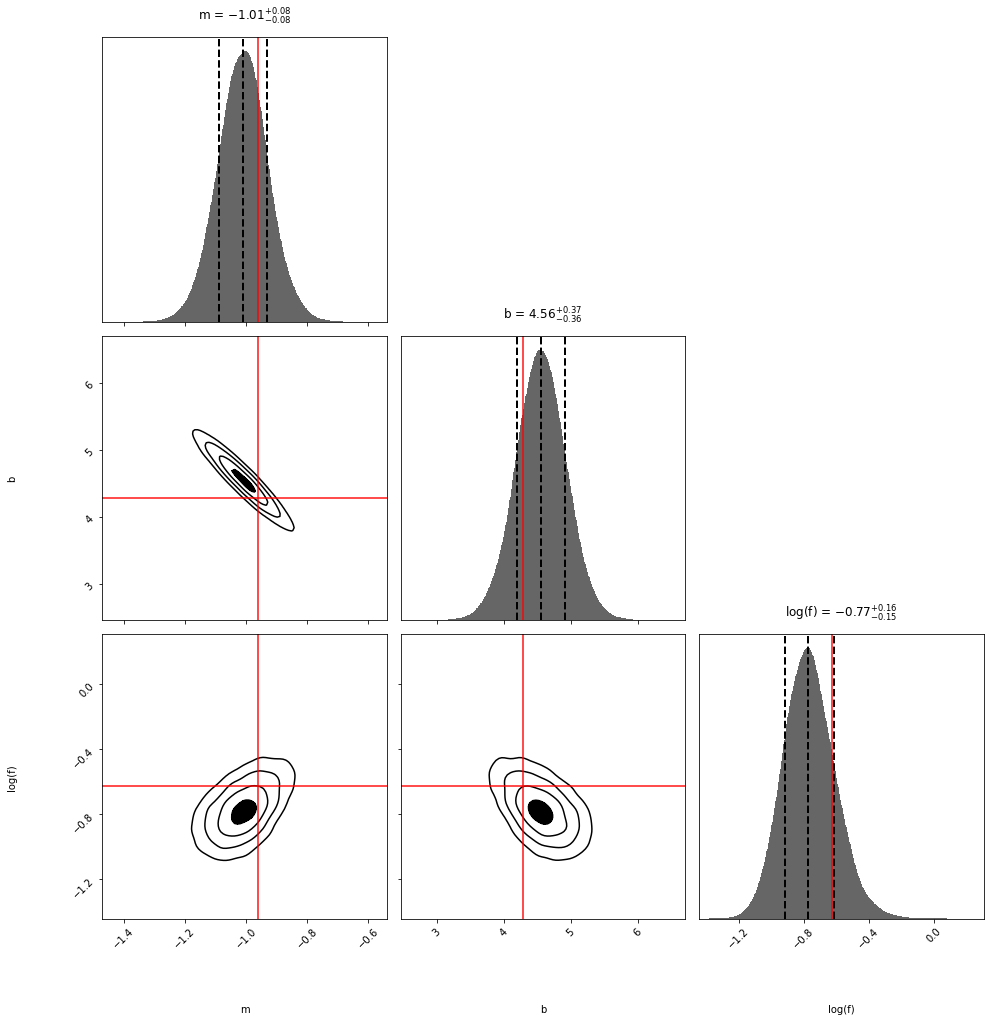

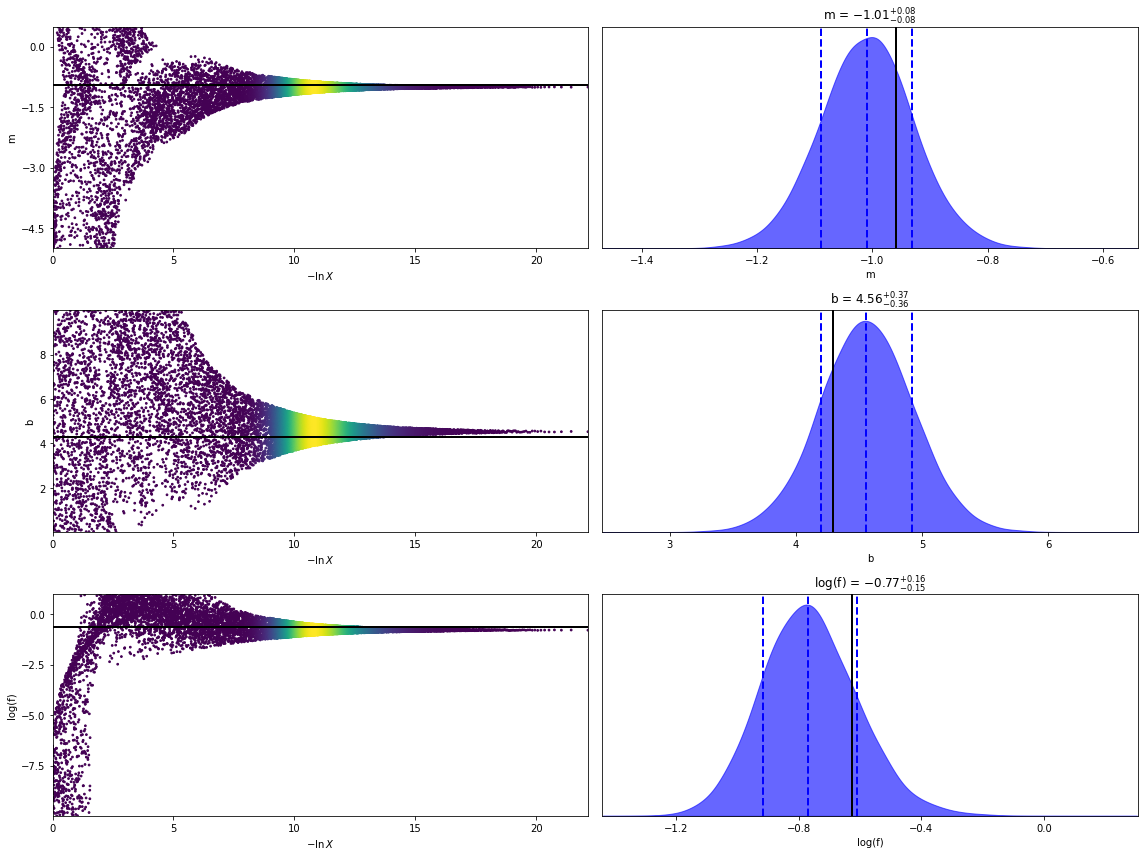

In [14]:
#Dynesty plots

truths = [m_true, b_true, np.log(f_true)]
labels = ["m", "b", "log(f)"]

fig, axes = dyplot.cornerplot(dres, truths=truths, quantiles=(0.16, 0.5, 0.84), show_titles=True, 
                              title_kwargs={'y': 1.04}, labels=labels,
                              fig=plt.subplots(3, 3, figsize=(15, 15)), title_quantiles=(0.16, 0.5, 0.84))


fig, axes = dyplot.traceplot(dres, truths=truths, quantiles=(0.16, 0.5, 0.84), labels=labels,
                             fig=plt.subplots(3, 2, figsize=(16, 12)),
                             truth_color='black', show_titles=True, title_quantiles=(0.16, 0.5, 0.84),
                             trace_cmap='viridis')
fig.tight_layout()


for i in range(ndim):
    q=np.array([0.16,0.5,0.84])
    sampx = np.atleast_1d(dres.samples[:,i])
    weights=dres.importance_weights()
    weights = np.atleast_1d(weights)
    idx = np.argsort(sampx)  # sort samples
    sw = weights[idx]  # sort weights
    cdf = np.cumsum(sw)[:-1]  # compute CDF
    cdf /= cdf[-1]  # normalize CDF
    cdf = np.append(0, cdf)  # ensure proper span
    quantiles = np.interp(q, cdf, sampx[idx]).tolist()
    err = np.diff(quantiles)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(quantiles[1], err[0], err[1], labels[i])
    display(Math(txt))
    
        
    
print("The evidence is:",np.exp(dres.logz[len(dres.logz)-1]))


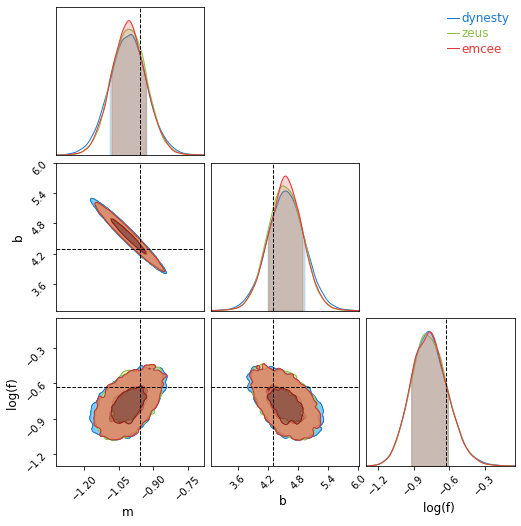

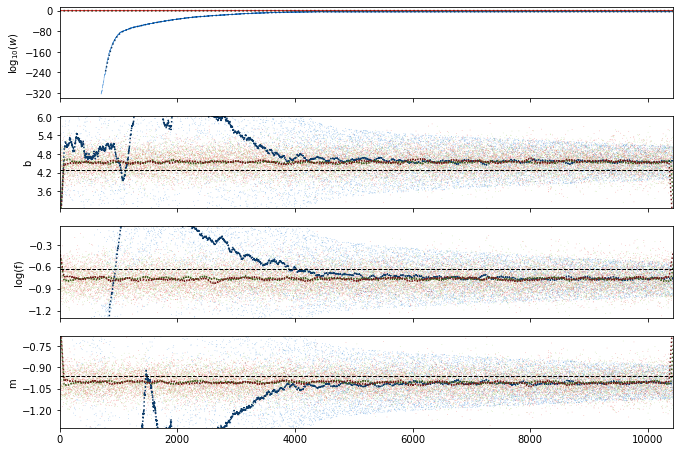

In [20]:
#Comparison plots

c = ChainConsumer()

c.add_chain(dres.samples, parameters=labels, weights=weights, name='dynesty')
c.add_chain(flat_zsamples, parameters=labels, name='zeus')
c.add_chain(flat_samples, parameters=labels, name='emcee')

c.configure(statistics='mean',legend_artists=True, sigma2d=True)

fig = c.plotter.plot(truth=truths)
fig1 = c.plotter.plot_walks(truth=truths, convolve=150)

fig.set_size_inches(3 + fig.get_size_inches())
fig1.set_size_inches(3 + fig1.get_size_inches())